Number of original MNIST training examples: 60000
Number of original MNIST test examples: 10000
Number of original Fashion MNIST training examples: 60000
Number of original Fashion MNIST test examples: 10000
Train on 60000 samples, validate on 10000 samples
Epoch 1/40
 2500/60000 [>.............................] - ETA: 40s - loss: 0.2371 - accuracy: 0.9292 - val_loss: 0.2294 - val_accuracy: 0.936310000/10000 - 0s - loss: 0.2294 - accuracy: 0.9363
Train on 60000 samples, validate on 10000 samples
Epoch 1/40
 2500/60000 [>.............................] - ETA: 43s - loss: 0.1600 - accuracy: 0.9512 - val_loss: 0.1370 - val_accuracy: 0.958710000/10000 - 0s - loss: 0.1370 - accuracy: 0.9587
Train on 60000 samples, validate on 10000 samples
Epoch 1/40
 2500/60000 [>.............................] - ETA: 2:16:15 - loss: 0.2104 - accuracy: 0.9332 - val_loss: 0.2125 - val_accuracy: 0.935710000/10000 - 95s - loss: 0.2125 - accuracy: 0.9357
Train on 60000 samples, validate on 10000 samples
Epoch 1/

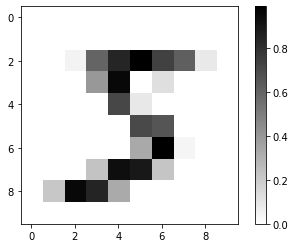

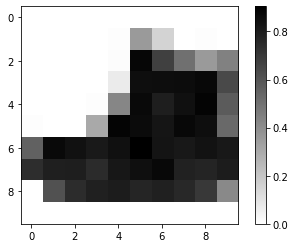

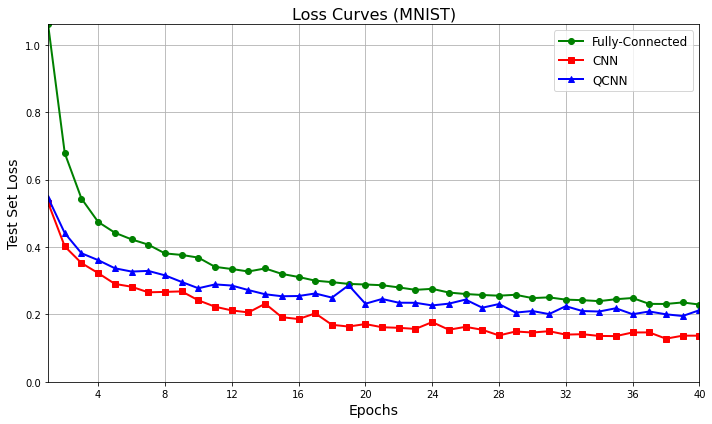

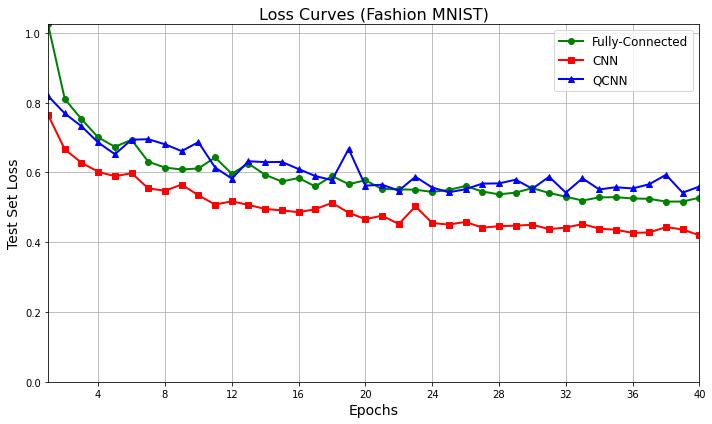

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

from tensorflow.keras import datasets, layers, models

import cirq
import sympy
import numpy as np
import collections

# visualization tools
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# Load the MNIST and Fashion MNIST datasets
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = tf.keras.datasets.fashion_mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train_mnist, x_test_mnist = x_train_mnist[..., np.newaxis] / 255.0, x_test_mnist[..., np.newaxis] / 255.0
x_train_fashion, x_test_fashion = x_train_fashion[..., np.newaxis] / 255.0, x_test_fashion[..., np.newaxis] / 255.0

print("Number of original MNIST training examples:", len(x_train_mnist))
print("Number of original MNIST test examples:", len(x_test_mnist))
print("Number of original Fashion MNIST training examples:", len(x_train_fashion))
print("Number of original Fashion MNIST test examples:", len(x_test_fashion))

# Cast the images to float32 and resize to 10x10
x_train_mnist = tf.image.resize(tf.cast(x_train_mnist, tf.float32), (10, 10)).numpy()
x_test_mnist = tf.image.resize(tf.cast(x_test_mnist, tf.float32), (10, 10)).numpy()
x_train_fashion = tf.image.resize(tf.cast(x_train_fashion, tf.float32), (10, 10)).numpy()
x_test_fashion = tf.image.resize(tf.cast(x_test_fashion, tf.float32), (10, 10)).numpy()

# Plot and save a sample from MNIST
fig = plt.figure()
plt.imshow(x_train_mnist[0, :, :, 0], cmap='gray_r')
plt.colorbar()
fig.savefig('sample_mnist', dpi=300)

# Plot and save a sample from Fashion MNIST
fig = plt.figure()
plt.imshow(x_train_fashion[0, :, :, 0], cmap='gray_r')
plt.colorbar()
fig.savefig('sample_fashion', dpi=300)

# Define a function to create and train a model
def create_and_train_model(model_type, x_train, y_train, x_test, y_test):
    width = np.shape(x_train)[1]
    height = np.shape(x_train)[2]
    
    if model_type == 'fc':
        model = models.Sequential([
            layers.Flatten(input_shape=(width, height, 1)),
            layers.Dense(32, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
    elif model_type == 'cnn':
        model = models.Sequential([
            layers.Conv2D(8, (2, 2), activation='relu', input_shape=(width, height, 1)),
            layers.Flatten(),
            layers.Dense(32, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
    elif model_type == 'qcnn':
        model = models.Sequential([
            QConv(filter_size=2, depth=8, activation='relu', name='qconv1', input_shape=(width, height, 1)),
            layers.Flatten(),
            layers.Dense(32, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, steps_per_epoch=500, validation_data=(x_test, y_test), epochs=40, batch_size=5)
    
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    return history, test_loss, test_acc, model

# Define the QConv layer (same as provided in the original code)

class QConv(tf.keras.layers.Layer):
    def __init__(self, filter_size, depth, activation=None, name=None, kernel_regularizer=None, **kwangs):
        super(QConv, self).__init__(name=name, **kwangs)
        self.filter_size = filter_size
        self.depth = depth
        self.learning_params = []
        self.QCNN_layer_gen()
        self.activation = tf.keras.layers.Activation(activation)
        self.kernel_regularizer = kernel_regularizer

    def _next_qubit_set(self, original_size, next_size, qubits):
        step = original_size // next_size
        qubit_list = []
        for i in range(0, original_size, step):
            for j in range(0, original_size, step):
                qubit_list.append(qubits[original_size*i + j])
        return qubit_list

    def _get_new_param(self):
        new_param = sympy.symbols("p"+str(len(self.learning_params)))
        self.learning_params.append(new_param)
        return new_param
    
    def _QConv(self, step, target, qubits):
        yield cirq.CZPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
        yield cirq.CXPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
        
    def QCNN_layer_gen(self):
        pixels = self.filter_size**2
        if np.log2(pixels) % 1 != 0:
            raise NotImplementedError("filter size: 2^n only available")
        cirq_qubits = cirq.GridQubit.rect(self.filter_size, self.filter_size)
        input_circuit = cirq.Circuit()
        input_params = [sympy.symbols('a%d' %i) for i in range(pixels)]
        for i, qubit in enumerate(cirq_qubits):
            input_circuit.append(cirq.rx(np.pi*input_params[i])(qubit))
        QCNN_circuit = cirq.Circuit()
        step_size = [2**i for i in range(np.log2(pixels).astype(np.int32))]
        for step in step_size:
            for target in range(0, pixels, 2*step):
                QCNN_circuit.append(self._QConv(step, target, cirq_qubits))
        full_circuit = cirq.Circuit()
        full_circuit.append(input_circuit)
        full_circuit.append(QCNN_circuit)
        self.circuit = full_circuit
        self.params = input_params + self.learning_params
        self.op = cirq.Z(cirq_qubits[0])
        
    def build(self, input_shape):
        self.width = input_shape[1]
        self.height = input_shape[2]
        self.channel = input_shape[3]
        self.num_x = self.width - self.filter_size + 1
        self.num_y = self.height - self.filter_size + 1
        
        self.kernel = self.add_weight(name="kenel", 
                                      shape=[self.depth, 
                                             self.channel, 
                                             len(self.learning_params)],
                                     initializer=tf.keras.initializers.glorot_normal(),
                                     regularizer=self.kernel_regularizer)
        self.circuit_tensor = tfq.convert_to_tensor([self.circuit] * self.num_x * self.num_y * self.channel)
        
    def call(self, inputs):
        stack_set = None
        for i in range(self.num_x):
            for j in range(self.num_y):
                slice_part = tf.slice(inputs, [0, i, j, 0], [-1, self.filter_size, self.filter_size, -1])
                slice_part = tf.reshape(slice_part, shape=[-1, 1, self.filter_size, self.filter_size, self.channel])
                if stack_set == None:
                    stack_set = slice_part
                else:
                    stack_set = tf.concat([stack_set, slice_part], 1)  
        stack_set = tf.transpose(stack_set, perm=[0, 1, 4, 2, 3])
        stack_set = tf.reshape(stack_set, shape=[-1, self.filter_size**2])
        circuit_inputs = tf.tile([self.circuit_tensor], [tf.shape(inputs)[0], 1])
        circuit_inputs = tf.reshape(circuit_inputs, shape=[-1])
        tf.fill([tf.shape(inputs)[0]*self.num_x*self.num_y, 1], 1)
        outputs = []
        for i in range(self.depth):
            controller = tf.tile(self.kernel[i], [tf.shape(inputs)[0]*self.num_x*self.num_y, 1])
            outputs.append(self.single_depth_QCNN(stack_set, controller, circuit_inputs))
        output_tensor = tf.stack(outputs, axis=3)
        output_tensor = tf.math.acos(tf.clip_by_value(output_tensor, -1+1e-5, 1-1e-5)) / np.pi
        return self.activation(output_tensor)
          
    def single_depth_QCNN(self, input_data, controller, circuit_inputs):
        input_data = tf.concat([input_data, controller], 1)
        QCNN_output = tfq.layers.Expectation()(circuit_inputs, 
                                               symbol_names=self.params,
                                               symbol_values=input_data,
                                               operators=self.op)
        QCNN_output = tf.reshape(QCNN_output, shape=[-1, self.num_x, self.num_y, self.channel])
        return tf.math.reduce_sum(QCNN_output, 3)

# Train and evaluate models on MNIST
fc_history_mnist, fc_loss_mnist, fc_acc_mnist, _ = create_and_train_model('fc', x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist)
cnn_history_mnist, cnn_loss_mnist, cnn_acc_mnist, _ = create_and_train_model('cnn', x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist)
qcnn_history_mnist, qcnn_loss_mnist, qcnn_acc_mnist, _ = create_and_train_model('qcnn', x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist)

# Train and evaluate models on Fashion MNIST
fc_history_fashion, fc_loss_fashion, fc_acc_fashion, _ = create_and_train_model('fc', x_train_fashion, y_train_fashion, x_test_fashion, y_test_fashion)
cnn_history_fashion, cnn_loss_fashion, cnn_acc_fashion, _ = create_and_train_model('cnn', x_train_fashion, y_train_fashion, x_test_fashion, y_test_fashion)
qcnn_history_fashion, qcnn_loss_fashion, qcnn_acc_fashion, _ = create_and_train_model('qcnn', x_train_fashion, y_train_fashion, x_test_fashion, y_test_fashion)

# Plot and save the loss curves
def plot_loss_curves(fc_loss, cnn_loss, qcnn_loss, dataset_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    epochs = np.arange(1, len(fc_loss) + 1)

    ax.plot(epochs, fc_loss, "go-", label="Fully-Connected", linewidth=2, markersize=6)
    ax.plot(epochs, cnn_loss, "rs-", label="CNN", linewidth=2, markersize=6)
    ax.plot(epochs, qcnn_loss, "b^-", label="QCNN", linewidth=2, markersize=6)

    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    ax.set_xlim([1, max(len(fc_loss), len(cnn_loss), len(qcnn_loss))])
    ax.set_ylim([0, max(max(fc_loss), max(cnn_loss), max(qcnn_loss))])
    ax.legend(fontsize=12, loc='upper right')
    ax.set_xlabel("Epochs", fontsize=14)
    ax.set_ylabel("Test Set Loss", fontsize=14)
    ax.grid(True)
    ax.set_title(f"Loss Curves ({dataset_name})", fontsize=16)

    plt.tight_layout()
    fig.savefig(f'loss_{dataset_name.lower()}.png', dpi=300)

plot_loss_curves(fc_history_mnist.history['val_loss'], cnn_history_mnist.history['val_loss'], qcnn_history_mnist.history['val_loss'], 'MNIST')
plot_loss_curves(fc_history_fashion.history['val_loss'], cnn_history_fashion.history['val_loss'], qcnn_history_fashion.history['val_loss'], 'Fashion MNIST')


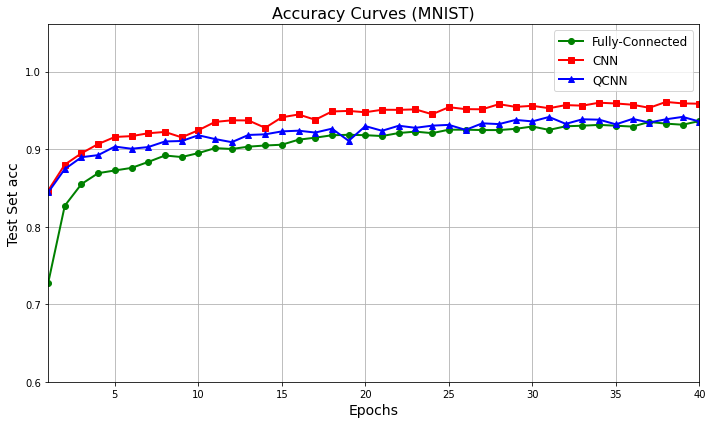

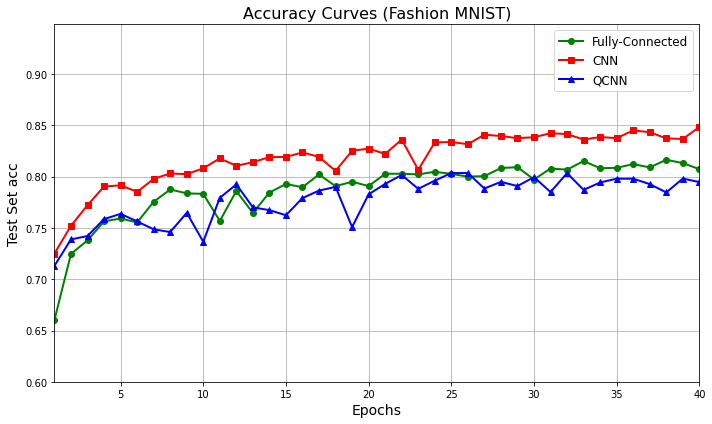

In [20]:
def plot_acc_curves(fc_acc, cnn_acc, qcnn_acc, dataset_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    epochs = np.arange(1, len(fc_acc) + 1)
    # Plot Accuracy Curves
    ax.plot(epochs, fc_acc, "go-", label="Fully-Connected", linewidth=2, markersize=6)
    ax.plot(epochs, cnn_acc, "rs-", label="CNN", linewidth=2, markersize=6)
    ax.plot(epochs, qcnn_acc, "b^-", label="QCNN", linewidth=2, markersize=6)

    ax.set_xlim([1, max(len(fc_acc), len(cnn_acc), len(qcnn_acc))])
    ax.set_ylim([0.6, max(max(fc_acc), max(cnn_acc), max(qcnn_acc))+0.1])
    ax.legend(fontsize=12, loc='upper right')
    ax.set_xlabel("Epochs", fontsize=14)
    ax.set_ylabel("Test Set acc", fontsize=14)
    ax.grid(True)
    ax.set_title(f"Accuracy Curves ({dataset_name})", fontsize=16)

    plt.tight_layout()
    fig.savefig(f'acc_{dataset_name.lower()}.png', dpi=300)

plot_acc_curves(fc_history_mnist.history['val_accuracy'], cnn_history_mnist.history['val_accuracy'], qcnn_history_mnist.history['val_accuracy'], 'MNIST')
plot_acc_curves(fc_history_fashion.history['val_accuracy'], cnn_history_fashion.history['val_accuracy'], qcnn_history_fashion.history['val_accuracy'], 'Fashion MNIST')
